<a href="https://colab.research.google.com/github/gabrie1-s/cnn-1d/blob/test/test_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
from pathlib import Path
import scipy.io
from glob import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import pandas as pd
from sklearn.preprocessing import normalize, label_binarize
from sklearn.model_selection import train_test_split, cross_val_score

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Aquisição dos Dados

In [ ]:
data = Path('drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/data')

signals = []
classes =[]

for value in sorted(data.glob('*.mat')):
  signal = scipy.io.loadmat(value)
  signal = np.array(signal["val"], dtype='float')[0]
  signals.append(signal)
  # print(value)
  
classification_path = os.path.join(data, "classification.txt")
with open(classification_path) as f:
    classes = f.readlines()

for i in range(0, len(classes)):
  classes[i] = classes[i][classes[i].find(','):]
  classes[i] = classes[i][: classes[i].find('\n')]
  classes[i] = classes[i].replace(",", "")

# 2. Preprocessamento

### 2.1 Análise da distribuição das classes

In [ ]:
d = {'signals': signals, 'classes': classes}
df = pd.DataFrame(data=d)
a = df.groupby('classes')
for i in ['N', 'O', 'A', '~']:
  print(i)
  aux = []

  for j in a.get_group(i)["signals"]:
    aux.append(len(j))

  print('Média:', round(np.mean(aux), 2))
  print("Std:", round(np.std(aux), 2))
  print("Qntd:", len(aux))
  print("Min:", min(aux))
  print("---------------")

N
Média: 9633.38
Std: 2991.84
Qntd: 5076
Min: 2714
---------------
O
Média: 10288.52
Std: 3528.74
Qntd: 2415
Min: 2738
---------------
A
Média: 9703.41
Std: 3694.64
Qntd: 758
Min: 2996
---------------
~
Média: 7313.63
Std: 3122.42
Qntd: 279
Min: 2808
---------------


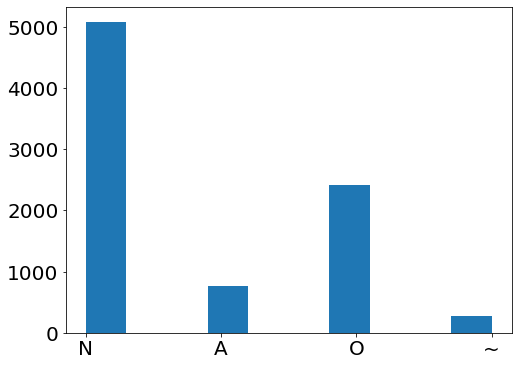

In [ ]:
plt.rcParams.update({'font.size': 20})

df["classes"].hist(
    figsize=(8, 6),
    grid = False,
    bins = 10,
)
plt.xticks(range(4))
plt.show()

### 2.2 Wavelet helping functions

In [ ]:
def gera_filtro_MH(Escala):
  passo = 1/Escala
  X = []
  a = -5
  X.append(a)
  while a <= 5:
    a=a+passo
    X.append(a)
  Y = []
  for i in range(0,len(X)):
    Y.append(2.1741*(1/math.sqrt(2*math.pi) * (1 - X[i]**2) * np.exp(-X[i]**2/(2))))
  return Y

def apply_wavelet(signal, level):
  Filtro = gera_filtro_MH(level)
  y = np.convolve(signal,Filtro)
  return y

### 2.3 Aplicação da tranformada Wavelet

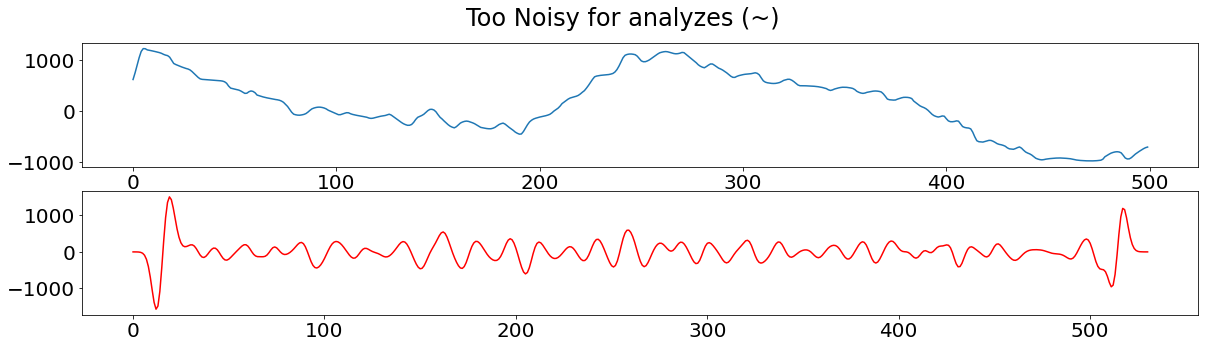

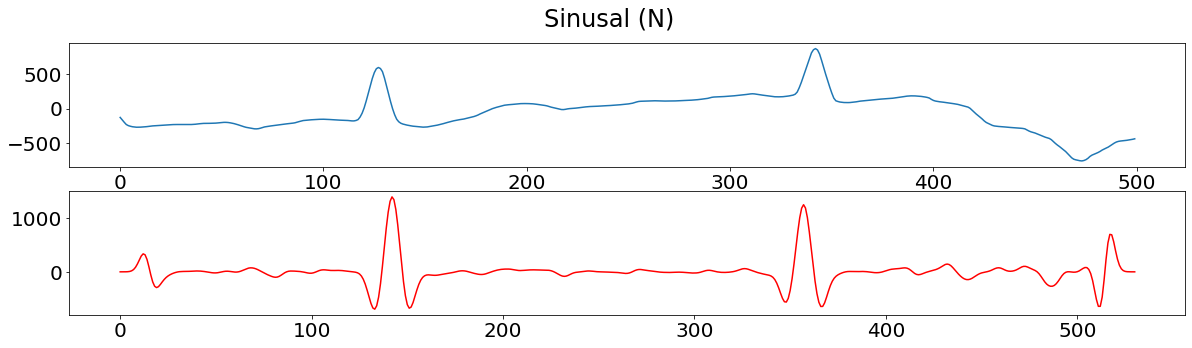

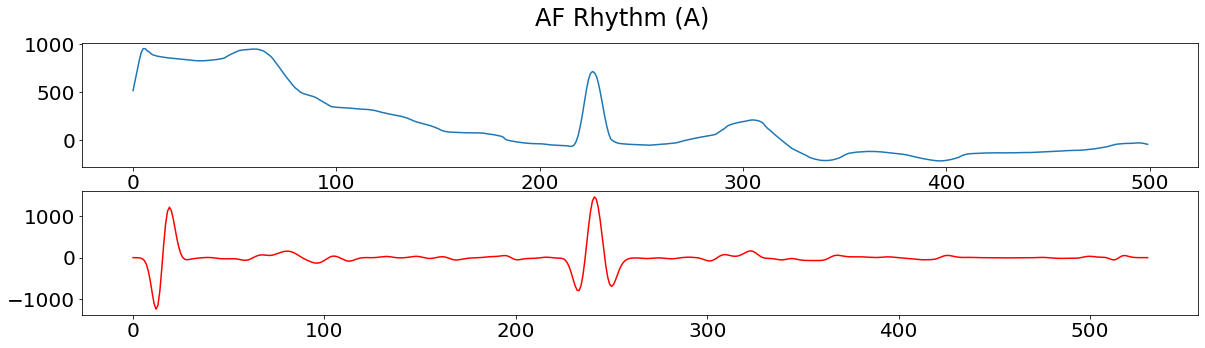

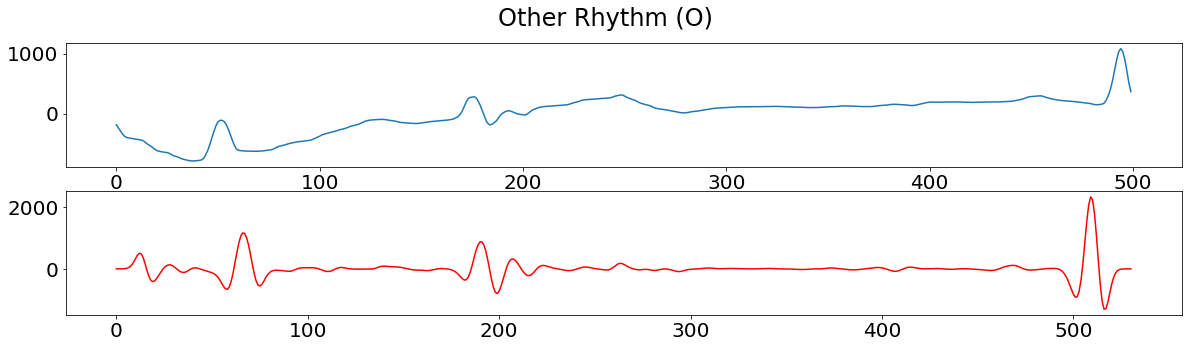

In [ ]:
plt.rcParams['figure.figsize']=(20,5)

signal = df[df["classes"] == '~'].iloc[0]["signals"][0:500]
fig, ax = plt.subplots(2,1)
fig.suptitle("Too Noisy for analyzes (~)")
z = apply_wavelet(signal, 3)
ax[0].plot(signal)
ax[1].plot(z, 'r')
plt.show()

signal = df[df["classes"] == 'N'].iloc[0]["signals"][0:500]
fig, ax = plt.subplots(2,1)
fig.suptitle("Sinusal (N)")
z = apply_wavelet(signal, 3)
ax[0].plot(signal)
ax[1].plot(z, 'r')
plt.show()

signal = df[df["classes"] == 'A'].iloc[0]["signals"][0:500]
fig, ax = plt.subplots(2,1)
fig.suptitle("AF Rhythm (A)")
z = apply_wavelet(signal, 3)
ax[0].plot(signal)
ax[1].plot(z, 'r')
plt.show()

signal = df[df["classes"] == 'O'].iloc[0]["signals"][0:500]
fig, ax = plt.subplots(2,1)
fig.suptitle("Other Rhythm (O)")
z = apply_wavelet(signal, 3)
ax[0].plot(signal)
ax[1].plot(z, 'r')
plt.show()


In [ ]:
x = []
for i in signals:
  val = apply_wavelet(i, 3)
  x.append(val)

### 2.4 Janelamento dos dados de treino

In [ ]:
intersection = 100
window_size = 500
windows_array = ["max","max","max","max"]
classes_array = ['N', 'O', 'A', '~']

In [ ]:
def window(signal, intersection, window_size, n):
  s_size = len(signal)
  max_n = (s_size-intersection)/(window_size - intersection)
  samples = []
  
  if  n == "max" or n > max_n:
    n = max_n
    n = math.floor(n)
    
  max_begin = s_size - (n*(window_size) - (n-1)*intersection)
  init = random.randrange(max_begin)
  for i in range(0, n):
    begin = init + i*window_size - i*intersection
    end = begin + window_size
    samples.append(signal[begin:end])

  
  return samples

In [ ]:
def embalance_data(df, classes_array, windows_array, intersection, window_size):

  a = df.groupby('classes')
  d_train = df.copy()
  d_train = d_train.iloc[0:0]


  idx = -1
  for i in classes_array:

    idx += 1

    for index, row in a.get_group(i).iterrows():
      samples = window(row["signals"], intersection, window_size,  windows_array[idx])
      
      for k in range(len(samples)):
        d_train = d_train.append({'signals': samples[k], 'classes': i}, ignore_index=True)

  return d_train

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, df["classes"], test_size=0.25)
d_aux = pd.DataFrame({'signals': x_train, 'classes': y_train})

d_train = embalance_data(d_aux, classes_array, windows_array, intersection, window_size)

b = d_train.groupby('classes')

for i in ['N','O', 'A', '~']:
  print(i)
  aux = []

  for j in b.get_group(i)["signals"]:
    aux.append(len(j))

  print('Média:', round(np.mean(aux), 2))
  print("Std:", round(np.std(aux), 2))
  print("Qntd:", len(aux))
  print("Min:", min(aux))
  print("---------------")

N
Média: 500.0
Std: 0.0
Qntd: 89909
Min: 500
---------------
O
Média: 500.0
Std: 0.0
Qntd: 45235
Min: 500
---------------
A
Média: 500.0
Std: 0.0
Qntd: 13510
Min: 500
---------------
~
Média: 500.0
Std: 0.0
Qntd: 3773
Min: 500
---------------


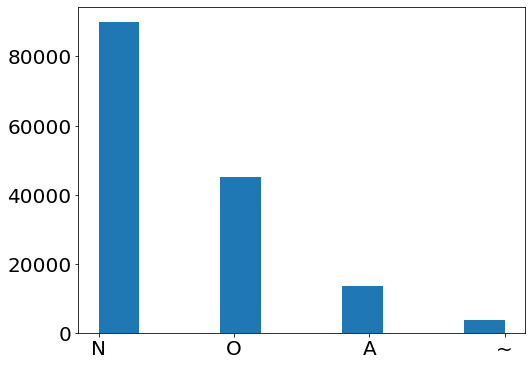

In [ ]:
plt.rcParams.update({'font.size': 20})

d_train["classes"].hist(
    figsize=(8, 6),
    grid = False,
    bins = 10,
)
plt.xticks(range(4))
plt.show()

In [ ]:
d_train = d_train.sample(frac=1, random_state=1)
signals_2 = d_train["signals"]
classes_2 = d_train["classes"]

### 2.4 "Normalização" do tamanho dos sinais

In [ ]:
# for i in range(0, len(x)):
#   val = normalize([x[i]])
#   x[i] = val[0]
# 3. Implementação da CNN

# 3. Implementação do modelo

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl

In [ ]:
y_train = classes_2
x_train = list(signals_2)

x_train = np.array(x_train)
# x_valid = np.array(x_valid)
x_test = np.array(x_test)

<ipython-input-17-7f9718a74ced>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test = np.array(x_test)


In [ ]:
# x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
# # x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
# x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], 1)

In [ ]:
# Import packages
from sklearn.model_selection import cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer, accuracy_score

pd.set_option("display.max_columns", None)

from sklearn import metrics
import tensorflow as tf

In [ ]:
score_acc = make_scorer(accuracy_score)

In [ ]:
def create_cnn(x_train, y_train):
  
  #x_train = np.array(list(x_train))
  x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
  y_train = pd.get_dummies(y_train)
  print(y_train.columns)

  input_shape = len(x_train[0])
  k1 = 5
  k2 = 3
  n = math.floor(input_shape/(k1+k2-2))
  nn_input = input_shape % (k1+k2-2)

  classificador = Sequential()

  for i  in range(0, 5):
    if i == 0:
      classificador.add(Conv1D(filters=64, kernel_size = k1, input_shape = (input_shape, 1), activation = "relu"))
    else:
        classificador.add(Conv1D(filters=64, kernel_size = k1, activation = "relu"))
    
    classificador.add(Conv1D(filters=32, kernel_size = k2, activation = "relu"))
    classificador.add(MaxPooling1D(pool_size=2))

  classificador.add(Flatten())

  classificador.add(Dense(units=64, activation='relu'))
  classificador.add(Dense(units=32, activation='relu'))
  classificador.add(Dense(units=64, activation='relu'))

  classificador.add(Dense(2, activation="softmax"))

  classificador.compile(loss='categorical_crossentropy', optimizer=Adamax(learning_rate=0.01), metrics=["accuracy"])


  es = EarlyStopping(monitor="accuracy", mode='max', verbose=0, patience=15)
  history = classificador.fit(x_train, y_train, epochs=150, batch_size=128, callbacks=es, verbose=1)
  
  return y_train.columns, classificador, history

# 4. Implementação da árvore

In [ ]:
# x_train = x_train[0:200]
# y_train = y_train[0:200]

In [ ]:
class RootNode:
  def __init__(self):
    self.child = None

In [ ]:
class BinaryTreeNode:
  def __init__(self, model, classe):
    self.columns = None
    self.classe = classe
    self.model = model
    self.leftChild = None
    self.rightChild=None

In [ ]:
def print_history(history, classe):
    plt.plot(history.history['accuracy'])
    plt.title('accuracy'+classe)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.savefig('plot '+classe+'.png')
    plt.show()

In [ ]:
def build_tree(x_train, y_train, classes_array):  
  
  for i in ['O', '~']:
    nan_v = []
    for j in classes_array:
      if j != i:
        nan_v.append(j)

    
    chosen = i

    y_next = y_train.replace(nan_v, "nan")
    columns, model, history = create_cnn(x_train, y_next)
    print_history(history, chosen)  



Index(['O', 'nan'], dtype='object')
Epoch 1/150
1191/1191 [==============================] - 16s 12ms/step - loss: 0.6193 - accuracy: 0.7077
Epoch 2/150
1191/1191 [==============================] - 15s 12ms/step - loss: 0.5764 - accuracy: 0.7206
Epoch 3/150
1191/1191 [==============================] - 14s 12ms/step - loss: 0.5635 - accuracy: 0.7313
Epoch 4/150
1191/1191 [==============================] - 15s 13ms/step - loss: 0.5532 - accuracy: 0.7376
Epoch 5/150
1191/1191 [==============================] - 15s 12ms/step - loss: 0.5429 - accuracy: 0.7458
Epoch 6/150
1191/1191 [==============================] - 14s 12ms/step - loss: 0.5357 - accuracy: 0.7509
Epoch 7/150
1191/1191 [==============================] - 15s 12ms/step - loss: 0.5306 - accuracy: 0.7545
Epoch 8/150
1191/1191 [==============================] - 14s 12ms/step - loss: 0.5241 - accuracy: 0.7595
Epoch 9/150
1191/1191 [==============================] - 15s 12ms/step - loss: 0.5192 - accuracy: 0.7620
Epoch 10/150
1191/1

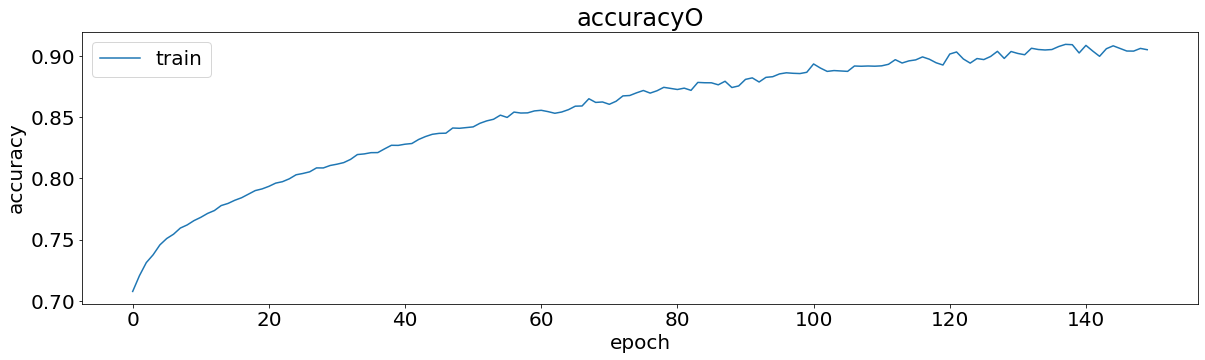

Index(['nan', '~'], dtype='object')
Epoch 1/150
1191/1191 [==============================] - 15s 12ms/step - loss: 0.1021 - accuracy: 0.9749
Epoch 2/150
1191/1191 [==============================] - 14s 12ms/step - loss: 0.0863 - accuracy: 0.9752
Epoch 3/150
1191/1191 [==============================] - 14s 12ms/step - loss: 0.0853 - accuracy: 0.9752
Epoch 4/150
1191/1191 [==============================] - 14s 12ms/step - loss: 0.0843 - accuracy: 0.9753
Epoch 5/150
1191/1191 [==============================] - 14s 12ms/step - loss: 0.0831 - accuracy: 0.9754
Epoch 6/150
1191/1191 [==============================] - 14s 12ms/step - loss: 0.0818 - accuracy: 0.9757
Epoch 7/150
1191/1191 [==============================] - 14s 12ms/step - loss: 0.0816 - accuracy: 0.9753
Epoch 8/150
1191/1191 [==============================] - 14s 12ms/step - loss: 0.0803 - accuracy: 0.9754
Epoch 9/150
1191/1191 [==============================] - 14s 12ms/step - loss: 0.0802 - accuracy: 0.9757
Epoch 10/150
1191/1

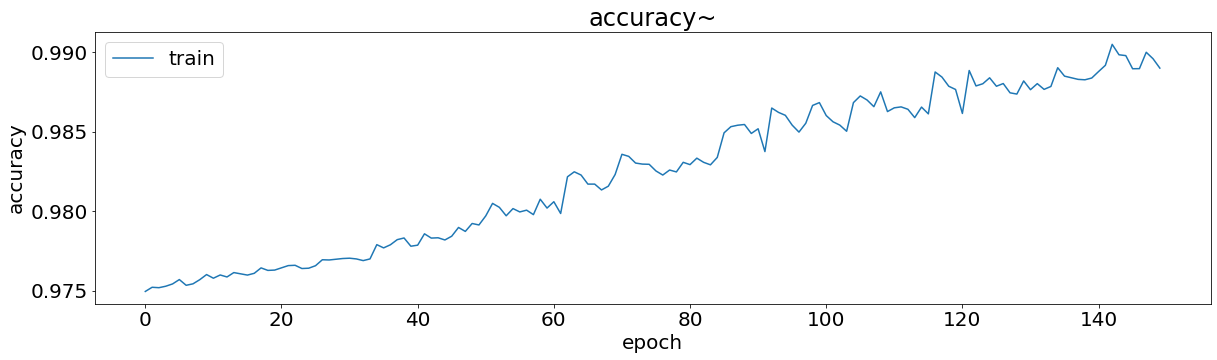

In [ ]:
classes_array = []
[classes_array.append(item) for item in y_train if item not in classes_array]
root = RootNode()
build_tree(x_train, y_train, classes_array)

In [ ]:
def make_prediction(current_node, samples):
    if type(current_node) == RootNode:
        current_node = current_node.child

    samples = window(signal, intersection, window_size, "max")
    samples = np.array(samples)
    samples = samples.reshape(samples.shape[0],samples.shape[1], 1)

    while current_node.model != None:
        model = current_node.model
        prediction = model.predict(samples)
        prediction = pd.DataFrame(prediction)
        prediction.columns = current_node.columns
        prediction = prediction.idxmax(axis=1)
        prediction = prediction.mode()[0]
        # print(prediction)

        if prediction == current_node.leftChild.classe:
            current_node = current_node.leftChild
        elif prediction == current_node.rightChild.classe:
            current_node = current_node.rightChild

    return current_node.classe

In [ ]:
y_pred = []
for signal in x_test:
    prediction = make_prediction(root, signal)
    y_pred.append(prediction)

In [ ]:
classes_list = []
for i in y_test:
    if i not in classes_list:
        classes_list.append(i)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

cf_matrix = confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = classes_list)
cm_display.plot()
plt.savefig("test.png")

In [ ]:
acc = accuracy_score(y_test, y_pred)

print("matriz de confusão:", cf_matrix)
print("labels:", classes_list)
print("acurácia:", acc)